In [63]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 2
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.numiActions = kwargs.get('numiActions', 15)
        self.numActions = self.numiActions ** self.numPlayers


        # Derived properties
        self.indexActions = self.init_indexActions()
        self.sdim, self.s0 = self.init_state()
        self.p_minmax = self.compute_p_competitive_monopoly()
        self.init_actions()
        
        self.Profits = self.init_Profits()
        self.Q = self.init_Q()
        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p):
        d = self.demand(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - self.c) * (1 - d) / self.mu + (p1 - self.c) * d1 / self.mu
        return np.squeeze(zero)

    
    def compute_p_competitive_monopoly(self):
        p0 = np.ones((1, self.numPlayers)) * 3 * self.c
        p_competitive = fsolve(self.foc, p0)
        p_monopoly = fsolve(self.foc_monopoly, p0)
        return p_competitive, p_monopoly

    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax[0]), max(self.p_minmax[1]), self.numiActions - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.numiActions)
        A = np.array(list(product(A, repeat=2)))
        self.action_list = A
        self.cost_list = self.action_list - self.mu*(1+1/(self.numPlayers-1 + \
                                      np.exp((self.a0-self.a+self.action_list)/self.mu)))
    
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    def init_state(self):
        sdim = (self.numiActions, self.numiActions)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0
    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p):
        d = self.demand(p)
        pi = (p - self.c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((self.numActions, self.numPlayers))
        for s in range(len(self.action_list)):
            Profits[s] = self.compute_profits(self.action_list[s])
        return Profits

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True)*(1-self.delta)
            
            Q[:, iReport,:] = np.ma.array(self.Profits,
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [64]:
b_model = betrand_model()
b_model.Profits

array([[0.20682553, 0.20682553],
       [0.22155186, 0.2070539 ],
       [0.23600529, 0.20482047],
       [0.2500352 , 0.20041303],
       [0.26350889, 0.19415033],
       [0.27631598, 0.18636658],
       [0.28837091, 0.17739646],
       [0.29961382, 0.16756186],
       [0.31000971, 0.15716109],
       [0.31954627, 0.14646121],
       [0.32823096, 0.13569327],
       [0.3360875 , 0.12505043],
       [0.34315225, 0.11468832],
       [0.34947076, 0.10472711],
       [0.35509455, 0.0952549 ],
       [0.2070539 , 0.22155186],
       [0.22292666, 0.22292666],
       [0.23866335, 0.22163041],
       [0.25409097, 0.21792449],
       [0.26905004, 0.2121133 ],
       [0.2834008 , 0.2045291 ],
       [0.29702771, 0.19551608],
       [0.30984202, 0.18541533],
       [0.32178241, 0.17455169],
       [0.33281401, 0.16322342],
       [0.34292597, 0.15169495],
       [0.35212819, 0.14019278],
       [0.36044761, 0.12890402],
       [0.36792429, 0.11797738],
       [0.37460776, 0.10752566],
       [0.

In [65]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)

        self.game = betrand_model(delta = self.delta,true_value = self.true_value_index,\
                                   reward = self.reward,penalty = self.penalty)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',10)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                maxVal = np.max(self.Q[state1,:,:],axis = 0)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (self.game.Profits[state2, iPlayer] + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1
                #print(strategyPrime,pPrime)
                # Assessing convergence
                if np.array_equiv(strategyPrime, pPrime):
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [68]:
K = betrand_Qlearning(numSessions = 100,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 1,penalty = 0,reward = 0,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



# print(R)
# print(K.game.cost_list[int(K.indexStrategies[0,:])],K.game.cost_list[int(K.indexStrategies[1,:])])

In [69]:
print(R)


(array([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0

In [60]:
lll = np.array([[2., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 2.,
        1., 1., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 2., 1., 1., 2.,
        2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2.,
        1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
        2., 1., 2., 2., 1., 2., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
        1., 1., 2., 2.],
       [2., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 2., 1., 1., 2.,
        1., 1., 2., 1., 1., 1., 1., 1., 2., 2., 2., 1., 2., 1., 1., 2.,
        2., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2.,
        1., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 1., 1., 2.,
        2., 1., 2., 2., 1., 2., 1., 1., 1., 2., 2., 2., 1., 1., 1., 1.,
        1., 1., 2., 2.]])

In [61]:
llll = lll
index =index0 = index1 = index2 = index3 = 0
for i in range(100):
    if llll[1,i] == llll[0,i]:
        index +=1
        if llll[1,i] == 0:
            index0 +=1
        if llll[1,i] == 1:
            index1 +=1
        if llll[1,i] == 2:
            index2 +=1
        if llll[1,i] == 3:
            index3 +=1

In [62]:
index/100,index0/100,index1/100,index2/100,index3/100

(1.0, 0.0, 0.61, 0.39, 0.0)

In [70]:
lll = np.array([[ 2., 10., 12.,  9.,  7.,  6.,  7.,  5.,  4.,  5.,  5.,  3.,  5.,
         6.,  7.,  4.,  4.,  1.,  8.,  2.,  4.,  8.,  7.,  5., 13.,  5.,
         4.,  3.,  4.,  5.,  8., 13.,  8., 13.,  2.,  5.,  4.,  2.,  3.,
         8.,  7., 12.,  7.,  5.,  8.,  5.,  0.,  9.,  8., 13.,  1.,  1.,
         5., 12.,  4.,  6.,  1., 12.,  9.,  7., 12., 11.,  0.,  7., 11.,
         5., 10.,  5.,  2.,  7.,  4.,  4.,  4.,  2., 12.,  6.,  8., 12.,
         5.,  1.,  5., 11.,  6.,  7.,  6.,  6.,  5., 13.,  9.,  3.,  7.,
         8.,  7.,  7.,  4.,  5.,  9.,  5.,  3.,  9.],
       [ 1., 13., 12.,  7.,  7.,  7.,  4.,  5.,  3.,  3.,  7.,  6.,  5.,
         3.,  4., 12.,  4.,  0.,  8.,  3.,  6.,  8.,  2.,  6., 12.,  4.,
         4.,  5.,  1.,  1.,  5., 12.,  8., 13.,  3.,  3.,  5.,  0.,  8.,
        10.,  7., 12.,  7.,  5.,  8.,  6.,  4.,  9.,  8., 13.,  4.,  1.,
         5.,  9.,  2.,  5.,  1.,  0.,  7.,  8., 11., 10.,  0.,  6., 11.,
         2., 11.,  4.,  0.,  7.,  1.,  5.,  5.,  0.,  1.,  3., 11., 11.,
         5.,  1.,  3.,  2.,  7.,  6.,  8.,  6.,  3., 12.,  8.,  4.,  7.,
        11.,  3.,  7.,  3., 10., 11.,  5.,  4.,  8.]])

In [74]:
llll = lll
index =index0 = index1 = index2 = index3 = index4 =index5 = \
    index6 = index7 = index8 = index9 =index10 = index11 = index12 = index13 = index14 = 0
for i in range(100):
    if llll[1,i] == llll[0,i]:
        index +=1
        if llll[1,i] == 0:
            index0 +=1
        if llll[1,i] == 1:
            index1 +=1
        if llll[1,i] == 2:
            index2 +=1
        if llll[1,i] == 3:
            index3 +=1
        if llll[1,i] == 4:
            index4 +=1
        if llll[1,i] == 5:
            index5 +=1
        if llll[1,i] == 6:
            index6 +=1
        if llll[1,i] == 7:
            index7 +=1
        if llll[1,i] == 8:
            index8 +=1
        if llll[1,i] == 9:
            index9 +=1
        if llll[1,i] == 10:
            index10 +=1
        if llll[1,i] == 11:
            index11 +=1
        if llll[1,i] == 12:
            index12 +=1
        if llll[1,i] == 13:
            index13 +=1
        if llll[1,i] == 14:
            index14 +=1


Text(0.5, 1.0, '0.30')

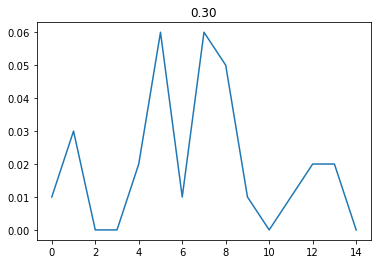

In [87]:
plt.plot(range(0,15),np.array([index0/100,index1/100,index2/100,index3/100,index4/100,index5/100,index6/100,index7/100,index8/100,\
index9/100,index10/100,index11/100,index12/100,index13/100,index14/100]))
plt.title('{:.2f}'.format(index/100))

In [77]:
import matplotlib.pyplot as plt